# 神经网络编程练习中

本章我们会逐步完成：
* 编码实现Dropout传播；
* 编码组合Affine-ReLU-Dropout层；
* 编码实现Dropout神经网络；
* 解耦神经网络；
* 正则化比较实验。

In [1]:
# -*- coding: utf-8 -*-
import time
import numpy as np
import matplotlib.pyplot as plt
from classifiers.chapter4 import *
from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ 返回相对误差 """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# 载入预处理后的数据
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Dropout 前向传播

由于Dropout的训练阶段和测试阶段采取不一样的传播方式，因此我们会设置“test”以及“train”模式。在训练模式时，我们会将单独的神经元激活概率P生成mask掩码层。该掩码层中为“0”的位置表明该位置处神经元处于抑制状态，为“1”的位置表明该处神经元可用。在测试阶段，我们去除掩码操作，直接返回输入结果即可。

执行下面的代码，进行检验。测试概率p与训练阶段输出0的平均个数相加与1接近。

Dropout使一部分神经元失活，那么该层神经元的输出均值就会缩小p倍。这在零均值的时候没有影响，但如果我们的神经元不是零均值分布的，那么可能就会收到影响。为了消除这种影响，我们使用mask=mask/p，这样就可以保证输出均值与输入均值相同，并且也间接放大了可用神经元的“影响力”。而现在神经元处于激活状态时，其输出值会被方法1/p倍。

In [3]:
from classifiers.chapter4.dropout_layers import *

x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('测试概率 p = ', p)
    print('均值输入: ', x.mean())
    print('训练阶段输出均值: ', out.mean())
    print('测试阶段输出均值: ', out_test.mean())
    print('训练阶段输出为0的平均个数: ',(out == 0).mean())
    print('测试阶段输出为0的平均个数: ',(out_test == 0).mean())

测试概率 p =  0.3
均值输入:  9.998715427214176
训练阶段输出均值:  10.065172915888757
测试阶段输出均值:  9.998715427214176
训练阶段输出为0的平均个数:  0.69798
测试阶段输出为0的平均个数:  0.0
测试概率 p =  0.6
均值输入:  9.998715427214176
训练阶段输出均值:  9.982967021634078
测试阶段输出均值:  9.998715427214176
训练阶段输出为0的平均个数:  0.400804
测试阶段输出为0的平均个数:  0.0
测试概率 p =  0.75
均值输入:  9.998715427214176
训练阶段输出均值:  9.998538139301417
测试阶段输出均值:  9.998715427214176
训练阶段输出为0的平均个数:  0.250004
测试阶段输出为0的平均个数:  0.0


## Dropout 反向传播

反向传播同样分为测试和训练两种模式。在测试阶段，仅仅返回上层梯度即可。在训练阶段需要将处于抑制状态神经元所对应的上层梯度设置为0。因此需要使用mask，其已经放在cache中。

当你完成编码工作后，执行下列代码块进行检验：

In [4]:
from utils import *

x = np.random.randn(10, 10) + 10
dout = np.random.randn( * x.shape )

dropout_param = { 'mode': 'train', 'p': 0.8, 'seed': 123 }
out, cache = dropout_forward( x, dropout_param )
dx = dropout_backward( dout, cache )
# 计算梯度
dx_num = eval_numerical_gradient_array( lambda xx: 
                                       dropout_forward( xx, dropout_param)[0], x, dout)

print('dx 相对误差: ', rel_error( dx, dx_num ))

dx 相对误差:  5.4456084067211455e-11


## Dropout全连接神经网络

接下来,我们将Dropout功能添加到深层全连接神经网络中。主要完成Dropout神经网络初始化以及损失函数的构建。

然后进行梯度校验。

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.2, 0.5,0.7]:
    print('检验 dropout率 = ', dropout)
    model = FullyConnectedNet(input_dim=D,hidden_dims=[H1, H2],    num_classes=C,
                                                        weight_scale=5e-2, dropout=dropout, seed=13)

    loss, grads = model.loss(X, y)
    print('初始化 loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s 相对误差: %.2e' % (name, rel_error(grad_num, grads[name])))
        
    print()

检验 dropout率 =  0
初始化 loss:  2.3051948273987857
W1 相对误差: 2.53e-07
W2 相对误差: 1.50e-05
W3 相对误差: 2.75e-07
b1 相对误差: 2.94e-06
b2 相对误差: 5.05e-08
b3 相对误差: 1.17e-10

检验 dropout率 =  0.2
初始化 loss:  2.2821321641253425
W1 相对误差: 7.28e-09
W2 相对误差: 8.40e-10
W3 相对误差: 5.63e-09
b1 相对误差: 1.64e-09
b2 相对误差: 2.21e-10
b3 相对误差: 1.48e-10

检验 dropout率 =  0.5
初始化 loss:  2.3011143171656236
W1 相对误差: 1.89e-07
W2 相对误差: 1.94e-06
W3 相对误差: 2.04e-08
b1 相对误差: 5.02e-08
b2 相对误差: 2.45e-09
b3 相对误差: 1.66e-10

检验 dropout率 =  0.7
初始化 loss:  2.3040345536668467
W1 相对误差: 1.77e-07
W2 相对误差: 7.78e-07
W3 相对误差: 3.39e-08
b1 相对误差: 1.77e-08
b2 相对误差: 3.20e-09
b3 相对误差: 8.99e-11



# trainer

解耦神经网络训练过程，打开`chapter4\trainer.py`阅读相关内容

In [6]:
model = None
trainer = None

D,H,C,std,r= 3*32*32,200,10,1e-2,0.6
model = FullyConnectedNet(input_dim=D, hidden_dims=[H], num_classes=C, weight_scale=std)
trainer = Trainer(model,data,update_rule='sgd',
                updater_config={'learning_rate': 1e-3,},
                lr_decay=0.95,num_epochs=20, batch_size=200,print_every=200)
trainer.train()

(迭代 1 / 4900) 损失值: 4.680202
(周期 0 / 20) 训练精度: 0.155000; 验证精度: 0.163000
(迭代 201 / 4900) 损失值: 1.954245
(周期 1 / 20) 训练精度: 0.335000; 验证精度: 0.361000
(迭代 401 / 4900) 损失值: 1.626711
(周期 2 / 20) 训练精度: 0.448000; 验证精度: 0.416000
(迭代 601 / 4900) 损失值: 1.764400
(周期 3 / 20) 训练精度: 0.460000; 验证精度: 0.446000
(迭代 801 / 4900) 损失值: 1.525576
(周期 4 / 20) 训练精度: 0.485000; 验证精度: 0.439000
(迭代 1001 / 4900) 损失值: 1.405463
(迭代 1201 / 4900) 损失值: 1.557814
(周期 5 / 20) 训练精度: 0.493000; 验证精度: 0.453000
(迭代 1401 / 4900) 损失值: 1.352051
(周期 6 / 20) 训练精度: 0.528000; 验证精度: 0.484000
(迭代 1601 / 4900) 损失值: 1.141143
(周期 7 / 20) 训练精度: 0.538000; 验证精度: 0.459000
(迭代 1801 / 4900) 损失值: 1.314146
(周期 8 / 20) 训练精度: 0.553000; 验证精度: 0.468000
(迭代 2001 / 4900) 损失值: 1.327610
(迭代 2201 / 4900) 损失值: 1.221952
(周期 9 / 20) 训练精度: 0.555000; 验证精度: 0.485000
(迭代 2401 / 4900) 损失值: 1.177750
(周期 10 / 20) 训练精度: 0.530000; 验证精度: 0.490000
(迭代 2601 / 4900) 损失值: 1.410634
(周期 11 / 20) 训练精度: 0.621000; 验证精度: 0.488000
(迭代 2801 / 4900) 损失值: 1.281012
(周期 12 / 20) 训练精度: 0.592

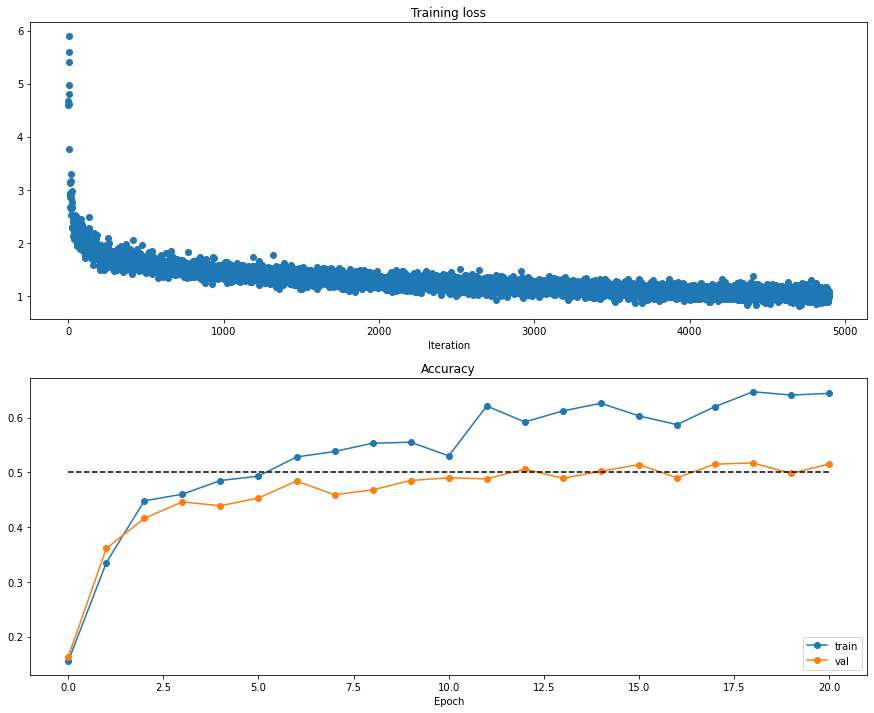

In [7]:
# 可视化训练/验证结果
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(trainer.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(trainer.train_acc_history, '-o', label='train')
plt.plot(trainer.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(trainer.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# 正则化实验

使用500训练数据进行正则化实验

In [8]:
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.3,0.7]
for dropout in dropout_choices:
    model = FullyConnectedNet(hidden_dims=[600], dropout=dropout)
    print("dropout激活概率(0表示不使用dropout)%f:"%dropout)

    trainer = Trainer(model, small_data,
                                    num_epochs=30, batch_size=100,
                                    update_rule='sgd',
                                    updater_config={
                                        'learning_rate': 5e-4,
                                    },
                                    verbose=True, print_every=200)
    trainer.train()
    solvers[dropout] = trainer

dropout激活概率(0表示不使用dropout)0.000000:
(迭代 1 / 150) 损失值: 9.543583
(周期 0 / 30) 训练精度: 0.198000; 验证精度: 0.154000
(周期 1 / 30) 训练精度: 0.276000; 验证精度: 0.200000
(周期 2 / 30) 训练精度: 0.382000; 验证精度: 0.246000
(周期 3 / 30) 训练精度: 0.408000; 验证精度: 0.207000
(周期 4 / 30) 训练精度: 0.608000; 验证精度: 0.271000
(周期 5 / 30) 训练精度: 0.722000; 验证精度: 0.281000
(周期 6 / 30) 训练精度: 0.738000; 验证精度: 0.279000
(周期 7 / 30) 训练精度: 0.812000; 验证精度: 0.271000
(周期 8 / 30) 训练精度: 0.910000; 验证精度: 0.273000
(周期 9 / 30) 训练精度: 0.892000; 验证精度: 0.312000
(周期 10 / 30) 训练精度: 0.956000; 验证精度: 0.282000
(周期 11 / 30) 训练精度: 0.944000; 验证精度: 0.287000
(周期 12 / 30) 训练精度: 0.982000; 验证精度: 0.289000
(周期 13 / 30) 训练精度: 0.986000; 验证精度: 0.305000
(周期 14 / 30) 训练精度: 0.994000; 验证精度: 0.290000
(周期 15 / 30) 训练精度: 1.000000; 验证精度: 0.297000
(周期 16 / 30) 训练精度: 0.998000; 验证精度: 0.289000
(周期 17 / 30) 训练精度: 0.996000; 验证精度: 0.293000
(周期 18 / 30) 训练精度: 0.996000; 验证精度: 0.293000
(周期 19 / 30) 训练精度: 1.000000; 验证精度: 0.298000
(周期 20 / 30) 训练精度: 1.000000; 验证精度: 0.300000
(周期 21 / 30) 训练精度: 1.00

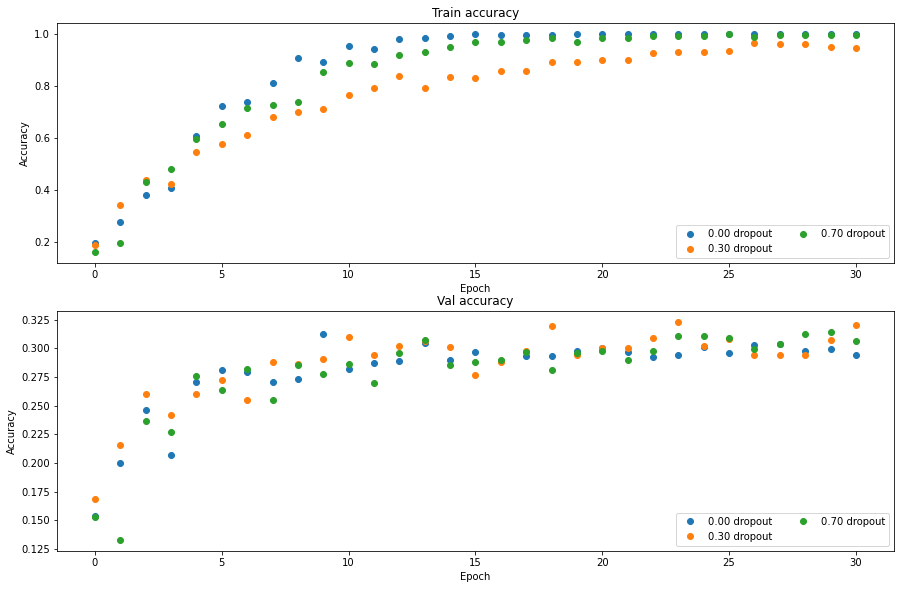

In [9]:
train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
    
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

(迭代 1 / 4900) 损失值: 2.310505
(周期 0 / 50) 训练精度: 0.118000; 验证精度: 0.092000
(周期 1 / 50) 训练精度: 0.242000; 验证精度: 0.240000
(周期 2 / 50) 训练精度: 0.277000; 验证精度: 0.275000
(周期 3 / 50) 训练精度: 0.267000; 验证精度: 0.301000
(迭代 301 / 4900) 损失值: 2.048633
(周期 4 / 50) 训练精度: 0.310000; 验证精度: 0.312000
(周期 5 / 50) 训练精度: 0.345000; 验证精度: 0.332000
(周期 6 / 50) 训练精度: 0.327000; 验证精度: 0.339000
(迭代 601 / 4900) 损失值: 1.893793
(周期 7 / 50) 训练精度: 0.338000; 验证精度: 0.353000
(周期 8 / 50) 训练精度: 0.353000; 验证精度: 0.363000
(周期 9 / 50) 训练精度: 0.389000; 验证精度: 0.363000
(迭代 901 / 4900) 损失值: 1.817221
(周期 10 / 50) 训练精度: 0.385000; 验证精度: 0.375000
(周期 11 / 50) 训练精度: 0.355000; 验证精度: 0.380000
(周期 12 / 50) 训练精度: 0.366000; 验证精度: 0.383000
(迭代 1201 / 4900) 损失值: 1.807873
(周期 13 / 50) 训练精度: 0.331000; 验证精度: 0.388000
(周期 14 / 50) 训练精度: 0.405000; 验证精度: 0.394000
(周期 15 / 50) 训练精度: 0.364000; 验证精度: 0.395000
(迭代 1501 / 4900) 损失值: 1.802722
(周期 16 / 50) 训练精度: 0.403000; 验证精度: 0.394000
(周期 17 / 50) 训练精度: 0.375000; 验证精度: 0.398000
(周期 18 / 50) 训练精度: 0.378000; 验证精度: 0.4

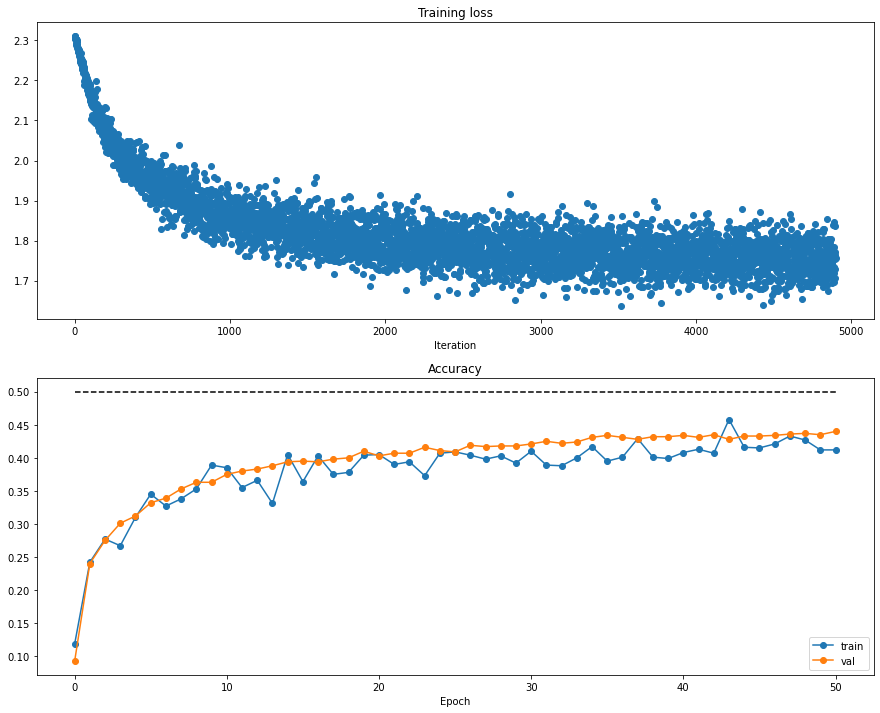

In [10]:
model = None
trainer = None

D,C,std,r= 3*32*32,10,1e-2,0.6
model = FullyConnectedNet(input_dim=D, hidden_dims=[100,50], num_classes=C, weight_scale=std, dropout=0.7)
trainer = Trainer(model,data,update_rule='sgd',
                updater_config={'learning_rate': 1e-3,},
                lr_decay=0.95,num_epochs=50, batch_size=500,print_every=300)
trainer.train()
# 可视化训练/验证结果
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(trainer.loss_history, 'o')
plt.xlabel('Iteration')
plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(trainer.train_acc_history, '-o', label='train')
plt.plot(trainer.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(trainer.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()